This notebook shows how we transform VED 1 from keras to pytorch 

In [1]:
import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

2022-10-31 16:17:44.863116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob


In [3]:
def sampling_to(mean,log_var):
    """
    reparameterization in pytorch 
    author: G. Behrens 
    """
    z_mean=mean
    z_log_var =log_var
    batch= z_mean.size(dim=0) #K.shape(z_mean)[0]
    dim=z_mean.size(dim=1)
    eps=to.normal(mean=0.0,std=1.0,size=(batch,dim))
    sampling_prob=z_mean+to.exp(0.5*z_log_var)*eps
    return sampling_prob

In [4]:
# define some hyperparameter
original_dim_input=109  # CBRAIN input node size

original_dim_output=int(113) # CBRAIN output node size 


# network parameters
latent_dim=13
intermediate_dim = 307
batch_size = 9213
kl_weight=6.802998765388219e-05
lr_init=0.0016118190605182029
act='elu'

input_shape = (original_dim_input,)
decoder_input_shape=(latent_dim,)
out_shape=(original_dim_output,)

In [5]:
# construct VED 1 in keras  

input_lay=Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation=act)(input_lay)
x_1 =Dense(intermediate_dim, activation=act)(x_0)
x_2 =Dense(intermediate_dim/2, activation=act)(x_1)
x_3 =Dense(intermediate_dim/4, activation=act)(x_2)
x_4 =Dense(intermediate_dim/8, activation=act)(x_3)
x_5 =Dense(intermediate_dim/16, activation=act)(x_4)
z_mean = Dense(latent_dim, name='z_mean')(x_5)
z_log_var = Dense(latent_dim, name='z_log_var')(x_5)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_lay, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
    
input_decoder=Input(shape=decoder_input_shape, name='decoder_input')
x_0 =Dense(intermediate_dim/16, activation=act)(input_decoder)
x_1 =Dense(intermediate_dim/8, activation=act)(x_0)
x_2 =Dense(intermediate_dim/4, activation=act)(x_1)
x_3 =Dense(intermediate_dim/2, activation=act)(x_2)
x_4 =Dense(intermediate_dim, activation=act)(x_3)
x_5 =Dense(intermediate_dim, activation=act)(x_4)


outputs_1= Dense(original_dim_output,activation=act)(x_5)
outputs_A = Dense(104,activation='linear')(outputs_1)
outputs_B = Dense(9,activation='relu')(outputs_1)
outputs= Concatenate()([outputs_A,outputs_B])
 
    
# instantiate encoder model
decoder = Model(input_decoder, outputs, name='decoder')
decoder.summary()
decoder_outputs=decoder(encoder(input_lay)[2])
VED_1=Model(input_lay,decoder_outputs, name='VED')
VED_1.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 109)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 307)          33770       ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 307)          94556       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 153)          47124       ['dense_1[0][0]']                
                                                                                            

2022-10-31 16:17:52.959597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
#load weights into keras VED 1 

VED_1.load_weights('real_geography/VEDs/VED_1/VED_1_weights.h5',by_name=True)
VED_1.summary()
VED_1_weights=VED_1.get_weights()



Model: "VED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 encoder (Functional)        [(None, 13),              191341    
                              (None, 13),                        
                              (None, 13)]                        
                                                                 
 decoder (Functional)        (None, 113)               205291    
                                                                 
Total params: 396,632
Trainable params: 396,632
Non-trainable params: 0
_________________________________________________________________


load pytorch

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
# construct Encoder and Decoder model 
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.X_1=nn.Linear(109,VED_1_weights[0].shape[1])
        self.X_2=nn.Linear(VED_1_weights[0].shape[1],VED_1_weights[2].shape[1])
        self.X_3=nn.Linear(VED_1_weights[2].shape[1],VED_1_weights[4].shape[1])
        self.X_4=nn.Linear(VED_1_weights[4].shape[1],VED_1_weights[6].shape[1])
        self.X_5=nn.Linear(VED_1_weights[6].shape[1],VED_1_weights[8].shape[1])
        self.X_6=nn.Linear(VED_1_weights[8].shape[1],VED_1_weights[10].shape[1])
        self.z_mean=nn.Linear(VED_1_weights[10].shape[1],VED_1_weights[12].shape[1])
        self.z_log_var=nn.Linear(VED_1_weights[10].shape[1],VED_1_weights[14].shape[1])
        
        

           
    def forward(self,x):
        
        x=F.elu(self.X_1(x))
        x=F.elu(self.X_2(x))
        x=F.elu(self.X_3(x))
        x=F.elu(self.X_4(x))
        x=F.elu(self.X_5(x))
        x=F.elu(self.X_6(x))
        x_1=self.z_mean(x)
        x_2=self.z_log_var(x)
        x=sampling_to(x_1,x_2)
            
        return x

        
        
        
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.X_1=nn.Linear(VED_1_weights[14].shape[1],VED_1_weights[16].shape[1])
        self.X_2=nn.Linear(VED_1_weights[16].shape[1],VED_1_weights[18].shape[1])
        self.X_3=nn.Linear(VED_1_weights[18].shape[1],VED_1_weights[20].shape[1])
        self.X_4=nn.Linear(VED_1_weights[20].shape[1],VED_1_weights[22].shape[1])
        self.X_5=nn.Linear(VED_1_weights[22].shape[1],VED_1_weights[24].shape[1])
        self.X_6=nn.Linear(VED_1_weights[24].shape[1],VED_1_weights[26].shape[1])
        self.X_7=nn.Linear(VED_1_weights[26].shape[1],VED_1_weights[28].shape[1])
        self.X_8=nn.Linear(VED_1_weights[28].shape[1],VED_1_weights[30].shape[1])
        self.X_9=nn.Linear(VED_1_weights[28].shape[1],VED_1_weights[32].shape[1])


    def forward(self,x):
        x=F.elu(self.X_1(x))
        x=F.elu(self.X_2(x))
        x=F.elu(self.X_3(x))
        x=F.elu(self.X_4(x))
        x=F.elu(self.X_5(x))
        x=F.elu(self.X_6(x))
        x=F.elu(self.X_7(x))

        x_1=self.X_8(x)
        x_2=F.relu(self.X_9(x))
        x=to.cat([x_1,x_2],1)

            
        return x

        
        
      
    
        



        


In [9]:
# initialize Encoder and Decoder 
Encoder_1=Encoder()
Decoder_1=Decoder()

print(Encoder_1)
print(Decoder_1)



Encoder(
  (X_1): Linear(in_features=109, out_features=307, bias=True)
  (X_2): Linear(in_features=307, out_features=307, bias=True)
  (X_3): Linear(in_features=307, out_features=153, bias=True)
  (X_4): Linear(in_features=153, out_features=76, bias=True)
  (X_5): Linear(in_features=76, out_features=38, bias=True)
  (X_6): Linear(in_features=38, out_features=19, bias=True)
  (z_mean): Linear(in_features=19, out_features=13, bias=True)
  (z_log_var): Linear(in_features=19, out_features=13, bias=True)
)
Decoder(
  (X_1): Linear(in_features=13, out_features=19, bias=True)
  (X_2): Linear(in_features=19, out_features=38, bias=True)
  (X_3): Linear(in_features=38, out_features=76, bias=True)
  (X_4): Linear(in_features=76, out_features=153, bias=True)
  (X_5): Linear(in_features=153, out_features=307, bias=True)
  (X_6): Linear(in_features=307, out_features=307, bias=True)
  (X_7): Linear(in_features=307, out_features=113, bias=True)
  (X_8): Linear(in_features=113, out_features=104, bias=T

In [10]:
VED_1_weights[15].shape

(13,)

In [11]:
VED_1_weights[13].shape

(13,)

In [12]:
VED_1_weights[11].shape

(19,)

In [13]:
VED_1_weights[16].shape


(13, 19)

In [14]:
VED_1_weights[17].shape


(19,)

In [15]:
VED_1_weights

[array([[-0.55340415, -0.00141103,  0.04380448, ..., -0.27182478,
          0.09583256,  0.02180052],
        [-0.79629534, -0.17814149, -0.4626062 , ..., -0.8070146 ,
          0.12692063,  0.28510964],
        [-0.83160233, -0.06257962, -0.89060605, ..., -1.0244797 ,
          0.25734615,  0.42787093],
        ...,
        [ 0.15387727, -0.5803689 , -0.7566882 , ...,  0.6155803 ,
         -0.13282461,  0.37565228],
        [-0.1183623 , -0.08516824, -0.9114703 , ...,  0.16003115,
         -0.57025796, -0.14626026],
        [ 0.23166904,  0.05968224, -0.11800817, ..., -0.6256291 ,
          0.00167961, -0.22478245]], dtype=float32),
 array([-2.46506706e-01, -1.61811560e-02,  4.85171378e-02,  1.52656406e-01,
        -7.72552341e-02, -7.06174457e-03, -7.23929107e-02, -2.37476170e-01,
        -2.69767940e-02, -4.88211811e-02, -5.31875435e-03, -1.60850540e-01,
         2.33548418e-01, -2.24785437e-03, -2.43492901e-01, -2.60426942e-03,
         6.96071051e-03,  5.59180938e-02, -1.97206318e

In [16]:
# load weights into pytroch Encoder 

Encoder_1.X_1.weight.data=to.from_numpy(np.transpose(VED_1_weights[0]))
Encoder_1.X_1.bias.data=to.from_numpy(np.transpose(VED_1_weights[1]))
Encoder_1.X_2.weight.data=to.from_numpy(np.transpose(VED_1_weights[2]))
Encoder_1.X_2.bias.data=to.from_numpy(np.transpose(VED_1_weights[3]))
Encoder_1.X_3.weight.data=to.from_numpy(np.transpose(VED_1_weights[4]))
Encoder_1.X_3.bias.data=to.from_numpy(np.transpose(VED_1_weights[5]))
Encoder_1.X_4.weight.data=to.from_numpy(np.transpose(VED_1_weights[6]))
Encoder_1.X_4.bias.data=to.from_numpy(np.transpose(VED_1_weights[7]))
Encoder_1.X_5.weight.data=to.from_numpy(np.transpose(VED_1_weights[8]))
Encoder_1.X_5.bias.data=to.from_numpy(np.transpose(VED_1_weights[9]))
Encoder_1.X_6.weight.data=to.from_numpy(np.transpose(VED_1_weights[10]))
Encoder_1.X_6.bias.data=to.from_numpy(np.transpose(VED_1_weights[11]))
Encoder_1.z_mean.weight.data=to.from_numpy(np.transpose(VED_1_weights[12]))
Encoder_1.z_mean.bias.data=to.from_numpy(np.transpose(VED_1_weights[13]))
Encoder_1.z_log_var.weight.data=to.from_numpy(np.transpose(VED_1_weights[14]))
Encoder_1.z_log_var.bias.data=to.from_numpy(np.transpose(VED_1_weights[15]))



In [17]:
# load weights into pytorch Decoder 

Decoder_1.X_1.weight.data=to.from_numpy(np.transpose(VED_1_weights[16]))
Decoder_1.X_1.bias.data=to.from_numpy(np.transpose(VED_1_weights[17]))
Decoder_1.X_2.weight.data=to.from_numpy(np.transpose(VED_1_weights[18]))
Decoder_1.X_2.bias.data=to.from_numpy(np.transpose(VED_1_weights[19]))
Decoder_1.X_3.weight.data=to.from_numpy(np.transpose(VED_1_weights[20]))
Decoder_1.X_3.bias.data=to.from_numpy(np.transpose(VED_1_weights[21]))
Decoder_1.X_4.weight.data=to.from_numpy(np.transpose(VED_1_weights[22]))
Decoder_1.X_4.bias.data=to.from_numpy(np.transpose(VED_1_weights[23]))
Decoder_1.X_5.weight.data=to.from_numpy(np.transpose(VED_1_weights[24]))
Decoder_1.X_5.bias.data=to.from_numpy(np.transpose(VED_1_weights[25]))
Decoder_1.X_6.weight.data=to.from_numpy(np.transpose(VED_1_weights[26]))
Decoder_1.X_6.bias.data=to.from_numpy(np.transpose(VED_1_weights[27]))
Decoder_1.X_7.weight.data=to.from_numpy(np.transpose(VED_1_weights[28]))
Decoder_1.X_7.bias.data=to.from_numpy(np.transpose(VED_1_weights[29]))
Decoder_1.X_8.weight.data=to.from_numpy(np.transpose(VED_1_weights[30]))
Decoder_1.X_8.bias.data=to.from_numpy(np.transpose(VED_1_weights[31]))
Decoder_1.X_9.weight.data=to.from_numpy(np.transpose(VED_1_weights[32]))
Decoder_1.X_9.bias.data=to.from_numpy(np.transpose(VED_1_weights[33]))


In [18]:
# define input and output vars 

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values
FSNS_std=scale_array.FSNS_std.values
FSNT_std=scale_array.FSNT_std.values
FLNS_std=scale_array.FLNS_std.values
FLNT_std=scale_array.FLNT_std.values
NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values




# defining the scaling dict for the VED training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}




# load vertical axis in pressure coords 


from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];



# load test data 
val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [19]:
# predict with keras VED 
pred_keras= VED_1.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 990us/step


In [20]:
print(pred_keras.shape)
pred_keras[0]

(13824, 113)


array([-4.57722749e-12, -5.55999691e-12, -1.14797061e-11, -5.96855898e-12,
       -2.77243089e-07,  2.61981040e-06, -1.79926610e-06, -6.51871233e-07,
       -1.19439210e-06, -9.65758227e-06, -3.76682729e-05, -1.31941400e-04,
       -2.37173401e-04, -3.47943977e-04, -2.74281949e-04,  2.49855220e-05,
        3.08750197e-04,  1.79249793e-04,  6.11685216e-04, -4.84660268e-06,
       -8.97184014e-04,  1.59895420e-03, -5.77286631e-03,  2.16884166e-03,
        6.79953769e-03, -3.36044282e-03,  5.20640686e-02,  7.15269148e-03,
       -2.28039920e-03,  1.72398239e-03,  4.37981263e-03,  4.39151004e-03,
        4.65305522e-03,  2.06929259e-03,  4.93977964e-03,  4.26520035e-03,
        3.70672345e-03,  1.53257325e-03,  4.91812825e-05,  1.24197453e-03,
        2.61172652e-04, -2.61967629e-03, -4.83976677e-03, -9.64960083e-03,
       -1.35418531e-02, -1.59950778e-02, -1.89183801e-02, -1.87608656e-02,
       -1.96234286e-02, -2.68024877e-02, -4.32000831e-02,  3.01978886e-02,
        1.36894940e-11, -

In [21]:
# predict with pytroch VED
pred_pytorch=Decoder_1(Encoder_1(to.from_numpy(val_gen_II[300][0])))
pred_pytorch[0]

tensor([-6.3594e-13, -7.6827e-13, -1.5916e-12, -8.2601e-13, -9.8148e-07,
         1.0446e-06, -1.6530e-06, -2.7017e-07,  1.0667e-06, -2.0125e-07,
        -4.4415e-06, -5.4276e-05, -1.2128e-04, -2.7562e-04, -3.9691e-04,
        -2.6251e-04, -9.4198e-05, -4.2754e-04, -1.0581e-03, -2.6443e-03,
        -1.0261e-04,  1.4726e-03,  9.0404e-04,  1.1958e-04,  2.7063e-03,
        -3.6138e-03,  3.7929e-02, -2.8661e-03, -8.8300e-03, -2.3340e-03,
         1.7704e-03,  2.8471e-03,  3.6682e-03,  8.8882e-04,  4.0753e-03,
         2.8193e-03,  2.3361e-03,  7.5785e-04,  1.4964e-04,  2.2321e-03,
         1.7574e-03, -2.3744e-03, -6.9958e-03, -1.3349e-02, -1.5894e-02,
        -1.5255e-02, -2.0400e-02, -2.5226e-02, -2.5692e-02, -2.9390e-02,
        -5.4368e-02,  3.3363e-02,  1.8998e-12, -5.7482e-14,  1.4779e-12,
         2.5224e-12,  2.8599e-12,  8.0602e-13, -1.9300e-12,  2.2284e-12,
         9.0017e-13, -1.1990e-12,  5.2536e-13,  4.2938e-14,  2.0639e-13,
         5.0071e-13,  3.8404e-06,  2.7672e-04,  9.1

In [22]:
pred_pytorch.shape

torch.Size([13824, 113])

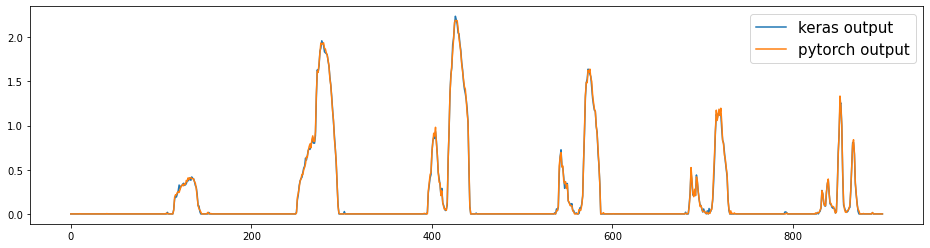

In [23]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

In [24]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=1E-3)

In [25]:
a.shape

(13824, 113)

In [26]:
np.where(a==False)[0].size

768110

In [27]:
np.where(a==True)[0].size

794002

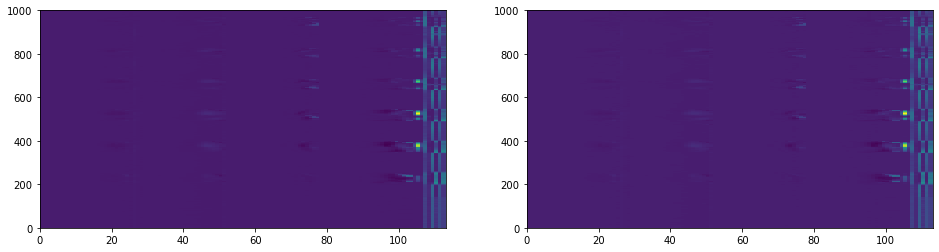

In [28]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])


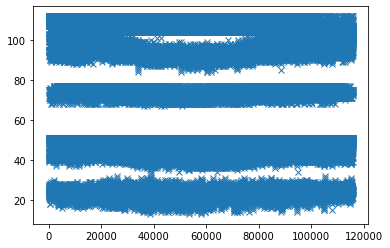

In [31]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-2)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [32]:
# save weights and biases 
to.save(Encoder_1,'real_geography/VEDs/VED_1/VEncoder_1_torch.pt')
to.save(Decoder_1,'real_geography/VEDs/VED_1/VDecoder_1_torch.pt')


In [33]:
# save Encoder model
enc_mod = to.jit.trace(Encoder_1, to.from_numpy(val_gen_II[300][0]))
to.jit.save(enc_mod,'real_geography/VEDs/VED_1/VEncoder_1_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 179694 / 179712 (100.0%)
Greatest absolute difference: 5.796384811401367 at index (1761, 3) (up to 1e-05 allowed)
Greatest relative difference: 322392.78830234765 at index (4653, 3) (up to 1e-05 allowed)
  _check_trace(


In [34]:
# save Decoder model 
dec_mod = to.jit.trace(Decoder_1, Encoder_1(to.from_numpy(val_gen_II[300][0])))
to.jit.save(dec_mod,'real_geography/VEDs/VED_1/VDecoder_1_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817698971/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad
